<a href="https://colab.research.google.com/github/zzoeys/freecakefridays/blob/main/Placing_of_Polling_Sites_Maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install the required libraries.

In [323]:
!pip install descartes
!pip install geopandas
!pip install matplotlib
!pip install numpy
!pip install pandas

In [324]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

This step reads the geodataframe which is in a shapefile format. The shapefile consists of the boundaries for every state of the United States. As our exploration focuses on Georgia, only Georgia's data is extracted.

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


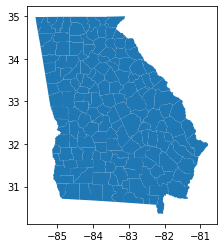

In [ ]:
geoData = "tl_2020_us_county.shp"
map_geo = gpd.read_file(geoData)

# Georgia is identified by '13' in the 'STATEFP' column of the geodataframe. 
county_geo=map_geo.loc[map_geo['STATEFP']=='13']
county_geo['NAME'] = county_geo['NAME'].str.upper()
county_geo.plot()

In [ ]:
county_geo

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
15,13,189,00348794,13189,MCDUFFIE,McDuffie County,06,H1,G4020,None,12260,None,A,666590014,23114032,+33.4806126,-082.4795333,"POLYGON ((-82.44998 33.34051, -82.45000 33.340..."
52,13,025,00351605,13025,BRANTLEY,Brantley County,06,H1,G4020,None,15260,None,A,1147972258,10291563,+31.1973339,-081.9829779,"POLYGON ((-81.91012 31.34722, -81.90993 31.347..."
53,13,171,00326713,13171,LAMAR,Lamar County,06,H1,G4020,122,12060,None,A,475264404,6044329,+33.0744405,-084.1466893,"POLYGON ((-84.24837 33.07856, -84.24837 33.079..."
82,13,115,00353665,13115,FLOYD,Floyd County,06,H1,G4020,122,40660,None,A,1320404595,22414013,+34.2636918,-085.2136851,"POLYGON ((-85.24134 34.41552, -85.24124 34.415..."
101,13,273,00352238,13273,TERRELL,Terrell County,06,H1,G4020,None,10500,None,A,869695791,4951325,+31.7771909,-084.4394464,"POLYGON ((-84.56317 31.77060, -84.57351 31.770..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3056,13,127,01671513,13127,GLYNN,Glynn County,06,H1,G4020,None,15260,None,A,1086851231,429107116,+31.2127098,-081.4964503,"POLYGON ((-81.66179 31.40430, -81.65878 31.408..."
3111,13,009,00345255,13009,BALDWIN,Baldwin County,06,H1,G4020,None,33300,None,A,670025212,24806035,+33.0594897,-083.2554566,"POLYGON ((-83.39272 33.03875, -83.39273 33.038..."
3142,13,111,00351094,13111,FANNIN,Fannin County,06,H1,G4020,None,None,None,A,1002597521,13473582,+34.8665427,-084.3173308,"POLYGON ((-84.38289 34.98800, -84.38279 34.988..."
3184,13,177,00343390,13177,LEE,Lee County,06,H1,G4020,None,10500,None,A,921731096,15310679,+31.8184185,-084.1466814,"MULTIPOLYGON (((-84.30520 31.69106, -84.30519 ..."


This step reads the racial density and extracts the last 5 digits of the geographical ID that identifies the county.

In [325]:
race =  pd.read_csv("/content/cleaned_georgia_race_county.csv")
race.id=race['id'].str.slice(start=-5)
race

,Unnamed: 0,Area Name,id,Total,Hispanic,White,Black,Asian,Mixed,Others,Population Density:Hispanic,Population Density: White,Population Density: Black,Population Density: Asian,Population Density: Mixed,Population Density: Others,Polling Site Density
0,0,"Appling County, Georgia",13001,18444,1825,12674,3339,123,417,66,0.098948,0.687161,0.181034,0.006669,0.022609,0.003578,0.000044
1,1,"Atkinson County, Georgia",13003,8286,2048,4801,1208,12,167,50,0.247164,0.579411,0.145788,0.001448,0.020154,0.006034,0.000237
2,2,"Bacon County, Georgia",13005,11140,875,8103,1747,40,335,40,0.078546,0.727379,0.156822,0.003591,0.030072,0.003591,0.000125
3,3,"Baker County, Georgia",13007,2876,143,1514,1128,18,70,3,0.049722,0.526426,0.392211,0.006259,0.024339,0.001043,0.000120
4,4,"Baldwin County, Georgia",13009,43799,1139,22432,18318,599,1027,284,0.026005,0.512158,0.418229,0.013676,0.023448,0.006484,0.001154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,154,"Whitfield County, Georgia",13313,102864,36916,57875,3553,1394,2621,505,0.358882,0.562636,0.034541,0.013552,0.025480,0.004909,0.002095
155,155,"Wilcox County, Georgia",13315,8766,272,5185,3096,49,149,15,0.031029,0.591490,0.353183,0.005590,0.016997,0.001711,0.001790
156,156,"Wilkes County, Georgia",13317,9565,399,4952,3838,59,277,40,0.041715,0.517721,0.401255,0.006168,0.028960,0.004182,0.000211
157,157,"Wilkinson County, Georgia",13319,8877,239,5110,3163,22,297,46,0.026924,0.575645,0.356314,0.002478,0.033457,0.005182,0.000196


This step merges the geodataframe and the csv dataframe with the racial density. It merges on the geographical ID. The county names are also capitalized for later merging.

In [ ]:
merged = county_geo.merge(race, how='left', left_on="GEOID", right_on="id")
merged = merged[['GEOID', 'NAME', 'Population Density:Hispanic', 'Population Density: White', 'Population Density: Black', 'Population Density: Asian', 'Population Density: Mixed', 'Population Density: Others']]
merged['NAME'] = merged['NAME'].str.upper()
merged

,GEOID,NAME,Population Density:Hispanic,Population Density: White,Population Density: Black,Population Density: Asian,Population Density: Mixed,Population Density: Others
0,13189,MCDUFFIE,0.036520,0.527783,0.399593,0.003513,0.028199,0.004392
1,13025,BRANTLEY,0.018090,0.905444,0.031186,0.002331,0.038400,0.004550
2,13171,LAMAR,0.025676,0.667243,0.264216,0.005514,0.033838,0.003514
3,13115,FLOYD,0.116307,0.687201,0.141402,0.013055,0.036091,0.005944
4,13273,TERRELL,0.019271,0.347197,0.603157,0.006206,0.021666,0.002504
...,...,...,...,...,...,...,...,...
154,13127,GLYNN,0.074983,0.627073,0.242240,0.013905,0.034474,0.007326
155,13009,BALDWIN,0.026005,0.512158,0.418229,0.013676,0.023448,0.006484
156,13111,FANNIN,0.029741,0.922272,0.003357,0.004463,0.034520,0.005648
157,13177,LEE,0.028737,0.686247,0.221060,0.025631,0.033381,0.004945


The polling site data for 2016, 2018 and 2020 are read as CSV files. The county name is capitalized for merging. The raw data consists of the addresses of polling sites in each county.

In [ ]:
polling_2016_path = "/content/Georgia_2016-11-08.csv"
polling_2018_path = "/content/Georgia_2018-11-06.csv"
polling_2020_path = "/content/Georgia_2020-11-03.csv"
pop_path = "/content/georgia_pop.csv"

polling_2016 = pd.read_csv(polling_2016_path)
polling_2018 = pd.read_csv(polling_2018_path)
polling_2020 = pd.read_csv(polling_2020_path)
pop = pd.read_csv(pop_path)

In [ ]:
polling_2016['county_name'] = polling_2016['county_name'].str.upper()
polling_2018['county_name'] = polling_2018['county_name'].str.upper()
polling_2020['county_name'] = polling_2020['county_name'].str.upper()

Each polling site address is in a separate row and has a county name. This step prepares the data by counting how many times a county is repeated in the 'county_name' column. This represents the number of polling sites in that county.

In [ ]:
new_polling_2016 = polling_2016['county_name'].value_counts().rename_axis('County').reset_index(name='2016 Quantity')
new_polling_2018 = polling_2018['county_name'].value_counts().rename_axis('County').reset_index(name='2018 Quantity')
new_polling_2020 = polling_2020['county_name'].value_counts().rename_axis('County').reset_index(name='2020 Quantity')

This step merges the number of polling sites data from 2016, 2018 and 2020 on the 'County' name column. The change in the number of polling sites is also calculated and added as new columns.



*   'Delta 18-20' represents the change in the quantity of polling sites from 2018 to 2020 in a county.
*   'Delta 16-18' represents the change in the quantity of polling sites from 2016 to 2018 in a county.
*   'Delta 16-2020' represents the change in the quantity of polling sites from 2016 to 2020 in a county.






In [ ]:
middle = new_polling_2016.merge(new_polling_2018, how='left', left_on="County", right_on="County")
polling = middle.merge(new_polling_2020, how='left', left_on="County", right_on="County")

polling = polling[['County', '2016 Quantity', '2018 Quantity', '2020 Quantity']]
polling['Delta 18-20'] = polling['2018 Quantity'] - polling['2020 Quantity']
polling['Delta 16-18'] = polling['2016 Quantity'] - polling['2018 Quantity']
polling['Delta 16-20'] = polling['2016 Quantity'] - polling['2020 Quantity']

polling

,County,2016 Quantity,2018 Quantity,2020 Quantity,Delta 18-20,Delta 16-18,Delta 16-20
0,FULTON,364,382,394,-12,-18,-30
1,DEKALB,191,191,193,-2,0,-2
2,GWINNETT,156,156,156,0,0,0
3,COBB,145,141,145,-4,4,0
4,CHATHAM,89,90,92,-2,-1,-3
...,...,...,...,...,...,...,...
154,RABUN,1,1,1,0,0,0
155,WEBSTER,1,1,1,0,0,0
156,CHATTAHOOCHEE,1,1,1,0,0,0
157,MILLER,1,1,1,0,0,0


This step merges the prepared polling dataframe on the geodataframe on the 'County' name.

In [ ]:
polling_geo=county_geo.merge(polling, how='left', left_on="NAME", right_on="County")

polling_geo = polling_geo[['NAME', '2016 Quantity', '2018 Quantity', '2020 Quantity', 'Delta 18-20', 'Delta 16-18', 'Delta 16-20', 'geometry']]
polling_geo

,NAME,2016 Quantity,2018 Quantity,2020 Quantity,Delta 18-20,Delta 16-18,Delta 16-20,geometry
0,MCDUFFIE,9,11,9,2,-2,0,"POLYGON ((-82.44998 33.34051, -82.45000 33.340..."
1,BRANTLEY,3,3,3,0,0,0,"POLYGON ((-81.91012 31.34722, -81.90993 31.347..."
2,LAMAR,6,6,6,0,0,0,"POLYGON ((-84.24837 33.07856, -84.24837 33.079..."
3,FLOYD,25,25,25,0,0,0,"POLYGON ((-85.24134 34.41552, -85.24124 34.415..."
4,TERRELL,6,6,6,0,0,0,"POLYGON ((-84.56317 31.77060, -84.57351 31.770..."
...,...,...,...,...,...,...,...,...
154,GLYNN,20,20,20,0,0,0,"POLYGON ((-81.66179 31.40430, -81.65878 31.408..."
155,BALDWIN,14,14,14,0,0,0,"POLYGON ((-83.39272 33.03875, -83.39273 33.038..."
156,FANNIN,12,12,12,0,0,0,"POLYGON ((-84.38289 34.98800, -84.38279 34.988..."
157,LEE,10,10,10,0,0,0,"MULTIPOLYGON (((-84.30520 31.69106, -84.30519 ..."


This step merges the racial density dataframe on the previous 'polling_geo' dataframe. It merges on the county 'NAME'.

In [ ]:
complete = polling_geo.merge(merged, how='left', left_on='NAME', right_on='NAME')
complete = complete[['NAME', '2016 Quantity', '2018 Quantity', '2020 Quantity', 'Delta 18-20', 'Delta 16-18', 'Delta 16-20', 'Population Density:Hispanic', 'Population Density: White', 'Population Density: Black', 'Population Density: Asian', 'Population Density: Mixed', 'Population Density: Others', 'geometry']]
complete

,NAME,2016 Quantity,2018 Quantity,2020 Quantity,Delta 18-20,Delta 16-18,Delta 16-20,Population Density:Hispanic,Population Density: White,Population Density: Black,Population Density: Asian,Population Density: Mixed,Population Density: Others,geometry
0,MCDUFFIE,9,11,9,2,-2,0,0.036520,0.527783,0.399593,0.003513,0.028199,0.004392,"POLYGON ((-82.44998 33.34051, -82.45000 33.340..."
1,BRANTLEY,3,3,3,0,0,0,0.018090,0.905444,0.031186,0.002331,0.038400,0.004550,"POLYGON ((-81.91012 31.34722, -81.90993 31.347..."
2,LAMAR,6,6,6,0,0,0,0.025676,0.667243,0.264216,0.005514,0.033838,0.003514,"POLYGON ((-84.24837 33.07856, -84.24837 33.079..."
3,FLOYD,25,25,25,0,0,0,0.116307,0.687201,0.141402,0.013055,0.036091,0.005944,"POLYGON ((-85.24134 34.41552, -85.24124 34.415..."
4,TERRELL,6,6,6,0,0,0,0.019271,0.347197,0.603157,0.006206,0.021666,0.002504,"POLYGON ((-84.56317 31.77060, -84.57351 31.770..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,GLYNN,20,20,20,0,0,0,0.074983,0.627073,0.242240,0.013905,0.034474,0.007326,"POLYGON ((-81.66179 31.40430, -81.65878 31.408..."
155,BALDWIN,14,14,14,0,0,0,0.026005,0.512158,0.418229,0.013676,0.023448,0.006484,"POLYGON ((-83.39272 33.03875, -83.39273 33.038..."
156,FANNIN,12,12,12,0,0,0,0.029741,0.922272,0.003357,0.004463,0.034520,0.005648,"POLYGON ((-84.38289 34.98800, -84.38279 34.988..."
157,LEE,10,10,10,0,0,0,0.028737,0.686247,0.221060,0.025631,0.033381,0.004945,"MULTIPOLYGON (((-84.30520 31.69106, -84.30519 ..."


A function is defined to calculate the center point of a polygon shape. This means that the center point of a county is calculated from the 'geometry' column. This process converts to the polygon geometry to a planar coordinate reference system (CRS), calculates the centroid point, and then converts the point back to the original CRS which is the CRS of the 'complete' dataframe.

In [ ]:
def calculate_center(df):

    original_crs = complete.crs
    planar_crs = 'EPSG:3857'
    return complete['geometry'].to_crs(planar_crs).centroid.to_crs(original_crs)

complete["center"] = calculate_center(complete)

complete.head()

,NAME,2016 Quantity,2018 Quantity,2020 Quantity,Delta 18-20,Delta 16-18,Delta 16-20,Population Density:Hispanic,Population Density: White,Population Density: Black,Population Density: Asian,Population Density: Mixed,Population Density: Others,geometry,center
0,MCDUFFIE,9,11,9,2,-2,0,0.036520,0.527783,0.399593,0.003513,0.028199,0.004392,"POLYGON ((-82.44998 33.34051, -82.45000 33.340...",POINT (-82.48144 33.48298)
1,BRANTLEY,3,3,3,0,0,0,0.018090,0.905444,0.031186,0.002331,0.038400,0.004550,"POLYGON ((-81.91012 31.34722, -81.90993 31.347...",POINT (-81.98184 31.19698)
2,LAMAR,6,6,6,0,0,0,0.025676,0.667243,0.264216,0.005514,0.033838,0.003514,"POLYGON ((-84.24837 33.07856, -84.24837 33.079...",POINT (-84.13947 33.07661)
3,FLOYD,25,25,25,0,0,0,0.116307,0.687201,0.141402,0.013055,0.036091,0.005944,"POLYGON ((-85.24134 34.41552, -85.24124 34.415...",POINT (-85.21423 34.26338)
4,TERRELL,6,6,6,0,0,0,0.019271,0.347197,0.603157,0.006206,0.021666,0.002504,"POLYGON ((-84.56317 31.77060, -84.57351 31.770...",POINT (-84.43694 31.77700)


This step creates a dataframe which drops the original 'geometry' column of the 'complete' dataframe, and renames the 'center' column to 'geometry'. This means that the geodataframe recognizes the centroid point as the 'geometry' of the county. This center point is where the points will be located on the bubble map.

In [ ]:
bubble = complete.drop(columns=["geometry"]).rename(columns={"center": "geometry"})
bubble.head()

,NAME,2016 Quantity,2018 Quantity,2020 Quantity,Delta 18-20,Delta 16-18,Delta 16-20,Population Density:Hispanic,Population Density: White,Population Density: Black,Population Density: Asian,Population Density: Mixed,Population Density: Others,geometry
0,MCDUFFIE,9,11,9,2,-2,0,0.036520,0.527783,0.399593,0.003513,0.028199,0.004392,POINT (-82.48144 33.48298)
1,BRANTLEY,3,3,3,0,0,0,0.018090,0.905444,0.031186,0.002331,0.038400,0.004550,POINT (-81.98184 31.19698)
2,LAMAR,6,6,6,0,0,0,0.025676,0.667243,0.264216,0.005514,0.033838,0.003514,POINT (-84.13947 33.07661)
3,FLOYD,25,25,25,0,0,0,0.116307,0.687201,0.141402,0.013055,0.036091,0.005944,POINT (-85.21423 34.26338)
4,TERRELL,6,6,6,0,0,0,0.019271,0.347197,0.603157,0.006206,0.021666,0.002504,POINT (-84.43694 31.77700)


This step creates dataframes that distinguishes between the counties which have an increase in polling sites, and counties which have a decrease in polling sites. To be able to view the bubble map at a visible scale, the size of the markers is equal to the change in the number of polling sites times a factor of 30. 


*   'decrease1820' and 'increase1820' are the dataframes of the change in polling sites from 2018 to 2020.
*   'decrease1618' and 'increase1618' are the dataframes of the change in polling sites from 2016 to 2018.
*   'decrease1620' and 'increase1620' are the dataframes of the change in polling sites from 2016 to 2020.





In [ ]:
decrease1820 = bubble[bubble['Delta 18-20']>0]
decrease1820['decrease marker'] = decrease1820['Delta 18-20']*30
increase1820 = bubble[bubble['Delta 18-20']<0]
increase1820['increase marker'] = increase1820['Delta 18-20']*(-30)

decrease1618 = bubble[bubble['Delta 16-18']>0]
decrease1618['decrease marker'] = decrease1820['Delta 16-18']*30
increase1618 = bubble[bubble['Delta 16-18']<0]
increase1618['increase marker'] = increase1820['Delta 16-18']*(-30)

decrease1620 = bubble[bubble['Delta 16-20']>0]
decrease1620['decrease marker'] = decrease1620['Delta 18-20']*30
increase1620 = bubble[bubble['Delta 16-20']<0]
increase1620['increase marker'] = increase1620['Delta 18-20']*(-30)

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

This step uses the Seaborn library to develop a colormap of blue to red.

In [ ]:
redblue = sns.diverging_palette(10, 240, center='light', as_cmap=True)

This step plots a bubble map with the change in quantity of polling sites from 2018 to 2020 over a bivariate choropleth map representing the white and black racial density distribution. 

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


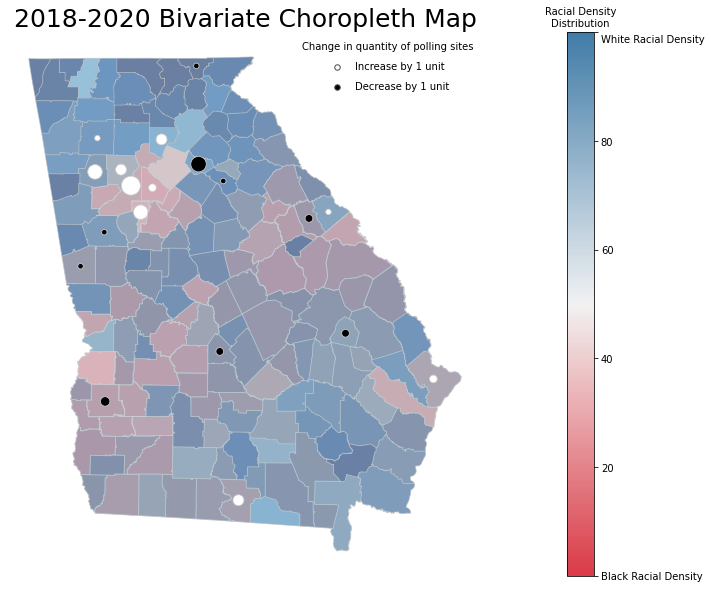

In [312]:
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 10))
# remove the axis
ax.axis('off')
# add a title
ax.set_title('2018-2020 Bivariate Choropleth Map', fontdict={'fontsize': '25', 'fontweight' : '3'})
# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap=redblue, norm=plt.Normalize(vmin=0, vmax=100))
# add the colorbar to the figure and add labels
colorbar=fig.colorbar(sm)
colorbar.ax.set_title('Racial Density\nDistribution',fontsize=10)
colorbar.ax.set_yticklabels(['Black Racial Density', '20', '40', '60', '80', '\nWhite Racial Density'])
# create map
complete.plot(column='Population Density: Black', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.7)
complete.plot(column='Population Density: White', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.6)
decrease1820.plot(column='Delta 18-20', marker='o', color='black', markersize='decrease marker', linewidth=0.8, ax=ax, edgecolor='0.8')
increase1820.plot(column='Delta 18-20', marker='o', color='white', markersize='increase marker', linewidth=0.8, ax=ax, edgecolor='0.8')
plt.scatter([], [], color='white', edgecolor='0.3', s=30, alpha=1, label='Increase by 1 unit')
plt.scatter([], [], color='black', edgecolor='0.3', s=30, alpha=1, label='Decrease by 1 unit')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Change in quantity of polling sites')

This step plots a bubble map with the change in quantity of polling sites from 2016 to 2018 over a bivariate choropleth map representing the white and black racial density distribution. 

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


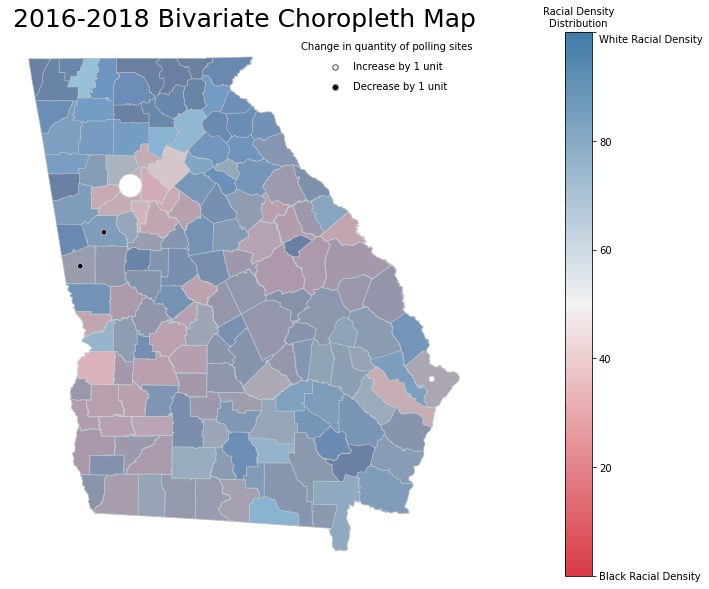

In [313]:
fig, ax = plt.subplots(1, figsize=(30, 10))
ax.axis('off')
ax.set_title('2016-2018 Bivariate Choropleth Map', fontdict={'fontsize': '25', 'fontweight' : '3'})
sm = plt.cm.ScalarMappable(cmap=redblue, norm=plt.Normalize(vmin=0, vmax=100))
colorbar=fig.colorbar(sm)
colorbar.ax.set_title('Racial Density\nDistribution',fontsize=10)
colorbar.ax.set_yticklabels(['Black Racial Density', '20', '40', '60', '80', '\nWhite Racial Density'])

complete.plot(column='Population Density: Black', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.7)
complete.plot(column='Population Density: White', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.6)
decrease1618.plot(column='Delta 16-18', marker='o', color='black', markersize='decrease marker', linewidth=0.8, ax=ax, edgecolor='0.8')
increase1618.plot(column='Delta 16-18', marker='o', color='white', markersize='increase marker', linewidth=0.8, ax=ax, edgecolor='0.8')
plt.scatter([], [], color='white', edgecolor='0.3', s=30, alpha=1, label='Increase by 1 unit')
plt.scatter([], [], color='black', edgecolor='0.3', s=30, alpha=1, label='Decrease by 1 unit')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Change in quantity of polling sites')

This step plots a bubble map with the change in quantity of polling sites from 2016 to 2020 over a bivariate choropleth map representing the white and black racial density distribution. 

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


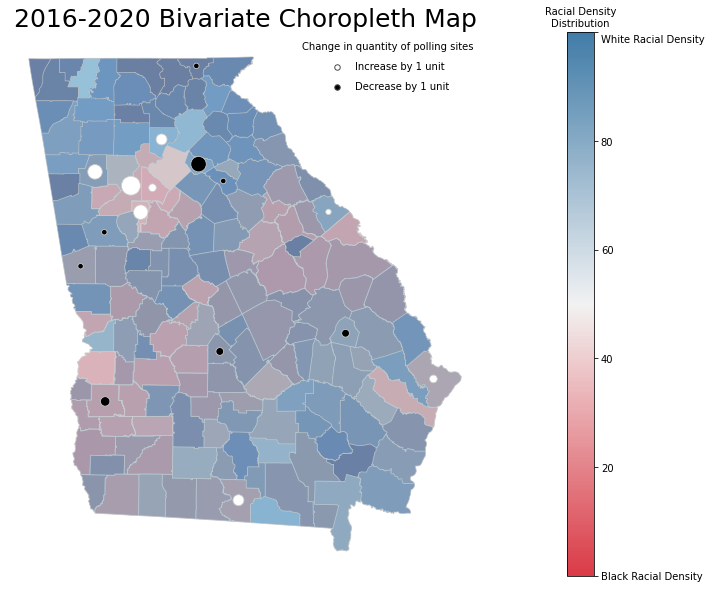

In [314]:
fig, ax = plt.subplots(1, figsize=(30, 10))
ax.axis('off')
ax.set_title('2016-2020 Bivariate Choropleth Map', fontdict={'fontsize': '25', 'fontweight' : '3'})
sm = plt.cm.ScalarMappable(cmap=redblue, norm=plt.Normalize(vmin=0, vmax=100))
colorbar=fig.colorbar(sm)
colorbar.ax.set_title('Racial Density\nDistribution',fontsize=10)
colorbar.ax.set_yticklabels(['Black Racial Density', '20', '40', '60', '80', '\nWhite Racial Density'])

complete.plot(column='Population Density: Black', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.7)
complete.plot(column='Population Density: White', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.6)
decrease1620.plot(column='Delta 16-20', marker='o', color='black', markersize='decrease marker', linewidth=0.8, ax=ax, edgecolor='0.8')
increase1620.plot(column='Delta 16-20', marker='o', color='white', markersize='increase marker', linewidth=0.8, ax=ax, edgecolor='0.8')
plt.scatter([], [], color='white', edgecolor='0.3', s=30, alpha=1, label='Increase by 1 unit')
plt.scatter([], [], color='black', edgecolor='0.3', s=30, alpha=1, label='Decrease by 1 unit')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Change in quantity of polling sites')

The following plots are bubble maps with the change in quantityof polling sites from 2018 to 2020 over a choropleth map of each racial density distribution (Hispanic, White, Black, Asian, Mixed, and Others).

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


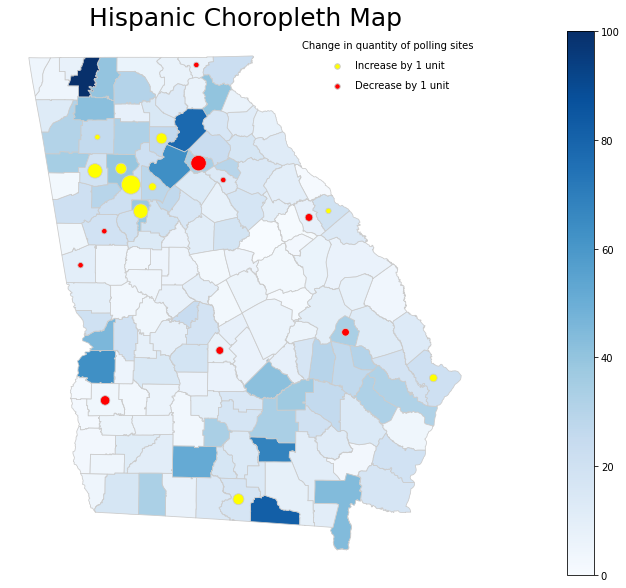

In [317]:
fig, ax = plt.subplots(1, figsize=(30, 10))
ax.axis('off')
ax.set_title('Hispanic Choropleth Map', fontdict={'fontsize': '25', 'fontweight' : '3'})
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=100))
fig.colorbar(sm)

complete.plot(column='Population Density:Hispanic', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
decrease1820.plot(column='Delta 18-20', marker='o', color='Red', markersize='decrease marker', linewidth=0.8, ax=ax, edgecolor='0.8')
increase1820.plot(column='Delta 18-20', marker='o', color='Yellow', markersize='increase marker', linewidth=0.8, ax=ax, edgecolor='0.8')
plt.scatter([], [], color='yellow', edgecolor='0.8', s=30, alpha=1, label='Increase by 1 unit')
plt.scatter([], [], color='red', edgecolor='0.8', s=30, alpha=1, label='Decrease by 1 unit')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Change in quantity of polling sites')

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


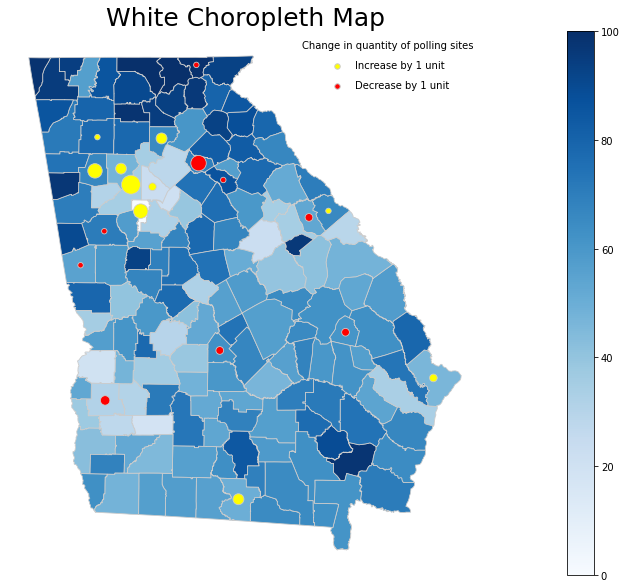

In [318]:
fig, ax = plt.subplots(1, figsize=(30, 10))
ax.axis('off')
ax.set_title('White Choropleth Map', fontdict={'fontsize': '25', 'fontweight' : '3'})
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=100))
fig.colorbar(sm)

complete.plot(column='Population Density: White', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
decrease1820.plot(column='Delta 18-20', marker='o', color='Red', markersize='decrease marker', linewidth=0.8, ax=ax, edgecolor='0.8')
increase1820.plot(column='Delta 18-20', marker='o', color='Yellow', markersize='increase marker', linewidth=0.8, ax=ax, edgecolor='0.8')
plt.scatter([], [], color='yellow', edgecolor='0.8', s=30, alpha=1, label='Increase by 1 unit')
plt.scatter([], [], color='red', edgecolor='0.8', s=30, alpha=1, label='Decrease by 1 unit')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Change in quantity of polling sites')

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


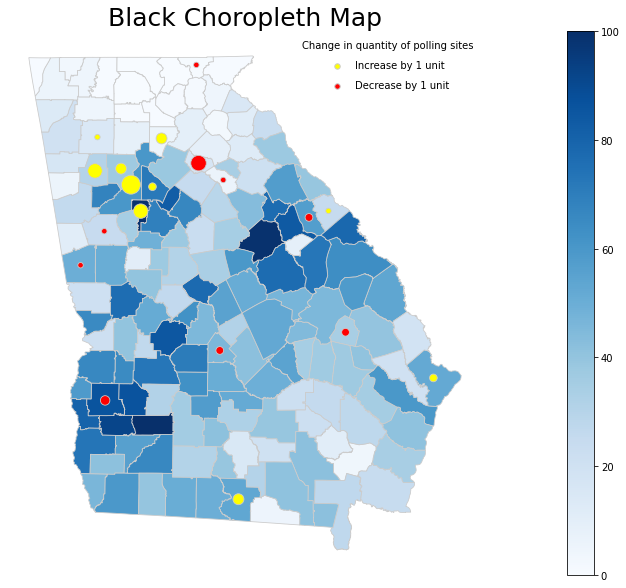

In [319]:
fig, ax = plt.subplots(1, figsize=(30, 10))
ax.axis('off')
ax.set_title('Black Choropleth Map', fontdict={'fontsize': '25', 'fontweight' : '3'})
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=100))
fig.colorbar(sm)

complete.plot(column='Population Density: Black', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
decrease1820.plot(column='Delta 18-20', marker='o', color='Red', markersize='decrease marker', linewidth=0.8, ax=ax, edgecolor='0.8')
increase1820.plot(column='Delta 18-20', marker='o', color='Yellow', markersize='increase marker', linewidth=0.8, ax=ax, edgecolor='0.8')
plt.scatter([], [], color='yellow', edgecolor='0.8', s=30, alpha=1, label='Increase by 1 unit')
plt.scatter([], [], color='red', edgecolor='0.8', s=30, alpha=1, label='Decrease by 1 unit')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Change in quantity of polling sites')

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


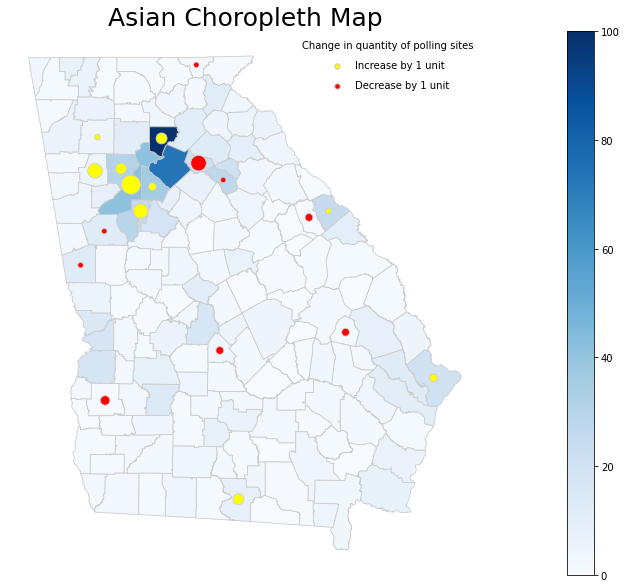

In [320]:
fig, ax = plt.subplots(1, figsize=(30, 10))
ax.axis('off')
ax.set_title('Asian Choropleth Map', fontdict={'fontsize': '25', 'fontweight' : '3'})
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=100))
fig.colorbar(sm)

complete.plot(column='Population Density: Asian', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
decrease1820.plot(column='Delta 18-20', marker='o', color='Red', markersize='decrease marker', linewidth=0.8, ax=ax, edgecolor='0.8')
increase1820.plot(column='Delta 18-20', marker='o', color='Yellow', markersize='increase marker', linewidth=0.8, ax=ax, edgecolor='0.8')
plt.scatter([], [], color='yellow', edgecolor='0.8', s=30, alpha=1, label='Increase by 1 unit')
plt.scatter([], [], color='red', edgecolor='0.8', s=30, alpha=1, label='Decrease by 1 unit')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Change in quantity of polling sites')

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


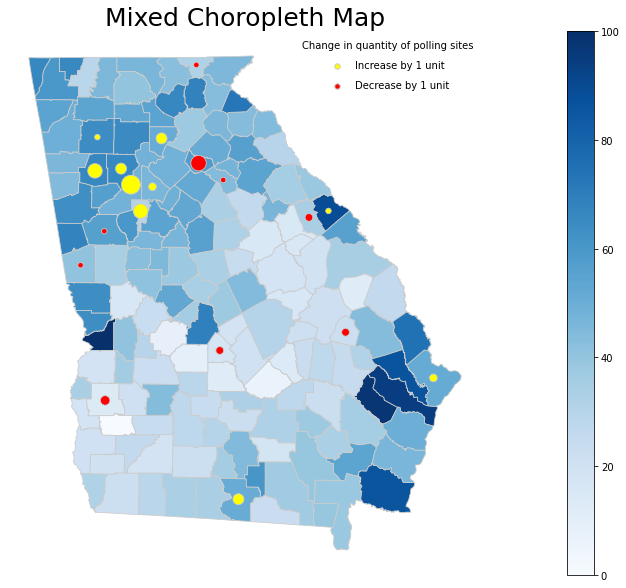

In [321]:
fig, ax = plt.subplots(1, figsize=(30, 10))
ax.axis('off')
ax.set_title('Mixed Choropleth Map', fontdict={'fontsize': '25', 'fontweight' : '3'})
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=100))
fig.colorbar(sm)

complete.plot(column='Population Density: Mixed', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
decrease1820.plot(column='Delta 18-20', marker='o', color='Red', markersize='decrease marker', linewidth=0.8, ax=ax, edgecolor='0.8')
increase1820.plot(column='Delta 18-20', marker='o', color='Yellow', markersize='increase marker', linewidth=0.8, ax=ax, edgecolor='0.8')
plt.scatter([], [], color='yellow', edgecolor='0.8', s=30, alpha=1, label='Increase by 1 unit')
plt.scatter([], [], color='red', edgecolor='0.8', s=30, alpha=1, label='Decrease by 1 unit')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Change in quantity of polling sites')

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


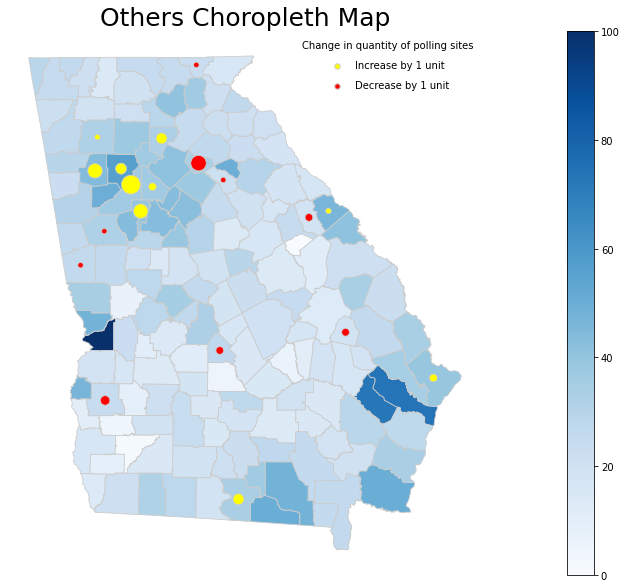

In [322]:
fig, ax = plt.subplots(1, figsize=(30, 10))
ax.axis('off')
ax.set_title('Others Choropleth Map', fontdict={'fontsize': '25', 'fontweight' : '3'})
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=100))
fig.colorbar(sm)

complete.plot(column='Population Density: Others', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
decrease1820.plot(column='Delta 18-20', marker='o', color='Red', markersize='decrease marker', linewidth=0.8, ax=ax, edgecolor='0.8')
increase1820.plot(column='Delta 18-20', marker='o', color='Yellow', markersize='increase marker', linewidth=0.8, ax=ax, edgecolor='0.8')
plt.scatter([], [], color='yellow', edgecolor='0.8', s=30, alpha=1, label='Increase by 1 unit')
plt.scatter([], [], color='red', edgecolor='0.8', s=30, alpha=1, label='Decrease by 1 unit')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Change in quantity of polling sites')